<a href="https://colab.research.google.com/github/opencoca/assem-vc/blob/master/Assem_VC_Inference_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference Example for Assem-VC
This script shows the example usage of pre-trained Assem-VC and HiFi-GAN.

---

"Assem-VC: Realistic Voice Conversion by Assembling Modern Speech Synthesis Techniques"

Author: Kang-wook Kim, Seung-won Park, Myun-chul Joe @ MINDsLab Inc., SNU 

Paper: https://arxiv.org/abs/2104.00931

Audio Samples: https://mindslab-ai.github.io/assem-vc

GitHub: https://github.com/mindslab-ai/assem-vc

In [ ]:
# Check GPU being used.
# To use GPU: Runtime > Change runtime type > GPU.
!nvidia-smi

Thu Jul 15 03:27:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone --recursive https://github.com/mindslab-ai/assem-vc.git

Cloning into 'assem-vc'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (335/335), done.
remote: Compressing objects: 100% (282/282), done.
remote: Total 335 (delta 68), reused 303 (delta 45), pack-reused 0
Receiving objects: 100% (335/335), 55.56 MiB | 34.54 MiB/s, done.
Resolving deltas: 100% (68/68), done.
Submodule 'hifi-gan' (https://github.com/wookladin/hifi-gan.git) registered for path 'hifi-gan'
Cloning into '/content/assem-vc/hifi-gan'...
remote: Enumerating objects: 62, done.        
remote: Counting objects: 100% (14/14), done.        
remote: Compressing objects: 100% (10/10), done.        
remote: Total 62 (delta 4), reused 9 (delta 3), pack-reused 48        
Submodule path 'hifi-gan': checked out '7395e41169e6549f62f941959675cc1fe7bf9735'


In [ ]:
cd assem-vc

/content/assem-vc


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 3.1MB 20.2MB/s 
     |████████████████████████████████| 245kB 52.3MB/s 
     |████████████████████████████████| 753.4MB 18kB/s 
     |████████████████████████████████| 2.8MB 22.9MB/s 
     |████████████████████████████████| 542kB 54.5MB/s 
     |████████████████████████████████| 276kB 53.2MB/s 
     |████████████████████████████████| 13.1MB 249kB/s 
     |████████████████████████████████| 419kB 54.0MB/s 
     |████████████████████████████████| 133kB 53.3MB/s 
     |████████████████████████████████| 184kB 56.6MB/s 
     |████████████████████████████████| 829kB 28.3MB/s 
     |████████████████████████████████| 122kB 48.9MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=1ef743454d8e4a95792108ae178d8ca9a6a0f1e68f762beb106cec683640b667
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for pysptk: filename=pysptk-0.1.18-cp37-cp37

In [ ]:
!pip uninstall -y torchtext

Uninstalling torchtext-0.10.0:
  Successfully uninstalled torchtext-0.10.0


## Import requirements

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import IPython.display as ipd
import gdown

import sys
sys.path.append('hifi-gan/')

import os
import numpy as np
import json
import librosa
import torch
import random
from omegaconf import OmegaConf
from env import AttrDict

from synthesizer import Synthesizer
from datasets import TextMelDataset, text_mel_collate
from models import Generator
from meldataset import MAX_WAV_VALUE

%matplotlib inline

In [ ]:
def plot_mel_f0_alignment(mel_source, mel_outputs_postnet, f0s, alignments, figsize=(16, 16)):
    fig, axes = plt.subplots(4, 1, figsize=figsize)
    axes = axes.flatten()
    axes[0].imshow(mel_source, aspect='auto', origin='lower', interpolation='none')
    axes[1].imshow(mel_outputs_postnet, aspect='auto', origin='lower', interpolation='none')
    axes[2].scatter(range(len(f0s)), f0s, alpha=0.5, color='red', marker='.', s=100)
    axes[2].set_xlim(0, len(f0s))
    axes[3].imshow(alignments, aspect='auto', origin='lower', interpolation='none')
    axes[0].set_title("Source Mel")
    axes[1].set_title("Predicted Mel")
    axes[2].set_title("Source pitch contour")
    axes[3].set_title("Source rhythm")
    plt.tight_layout()

## Download pre-trained weights and config files

The pre-trained decoder file also contains the cotatron by itself.

In [ ]:
gdown.download('https://drive.google.com/uc?id=1gt_rLVw83-FMtvTv6PJ5hdqZQRiyaQnh', 'config/global/config.yaml', quiet=False)
gdown.download('https://drive.google.com/uc?id=1kKwchYCAB1A67ELI1LQcpjrYFnSmiPYS', 'config/vc/config.yaml', quiet=False)
gdown.download('https://drive.google.com/uc?id=1dKN4knY0mSBKWZqjP_sX8W_EJSV-7bNP', 'f0s.txt', quiet=False)
gdown.download('https://drive.google.com/uc?id=1k2uJBh3FEK38pCdH38-MaXpgJFb5sEk6', 'pretrained_decoder.ckpt', quiet=False)
gdown.download('https://drive.google.com/uc?id=1Q1XCoY_SKno34dLLm1zNu6PtKuqumXYi', 'hifigan_vctk_g_2600000.ckpt', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gt_rLVw83-FMtvTv6PJ5hdqZQRiyaQnh
To: /content/assem-vc/config/global/config.yaml
100%|██████████| 3.06k/3.06k [00:00<00:00, 1.04MB/s]
Downloading...
From: https://drive.google.com/uc?id=1kKwchYCAB1A67ELI1LQcpjrYFnSmiPYS
To: /content/assem-vc/config/vc/config.yaml
100%|██████████| 338/338 [00:00<00:00, 94.0kB/s]
Downloading...
From: https://drive.google.com/uc?id=1dKN4knY0mSBKWZqjP_sX8W_EJSV-7bNP
To: /content/assem-vc/f0s.txt
100%|██████████| 9.81k/9.81k [00:00<00:00, 2.32MB/s]
Downloading...
From: https://drive.google.com/uc?id=1k2uJBh3FEK38pCdH38-MaXpgJFb5sEk6
To: /content/assem-vc/pretrained_decoder.ckpt
168MB [00:00, 183MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Q1XCoY_SKno34dLLm1zNu6PtKuqumXYi
To: /content/assem-vc/hifigan_vctk_g_2600000.ckpt
55.8MB [00:00, 145MB/s] 


'hifigan_vctk_g_2600000.ckpt'

## Load models from checkpoint

write down your paths below.

In [ ]:
vc_decoder_path = 'pretrained_decoder.ckpt' # path of vc decoder checkpoint
generator_path = 'hifigan_vctk_g_2600000.ckpt' # path of hifi-gan checkpoint
config_path = 'hifi-gan/config_v1.json' # path of hifi-gan's configuration

In [ ]:
print("Loading Synthesizer's checkpoint...")
net=Synthesizer.load_from_checkpoint(vc_decoder_path).cuda().eval()
net.freeze()

hp =net.hp
print("Complete.")

Loading Synthesizer's checkpoint...
Complete.


In [ ]:
with open(config_path) as f:
    data = f.read()

json_config = json.loads(data)
h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).cuda().eval()

print("Loading Generator's checkpoint...")

state_dict_g = torch.load(generator_path, map_location='cpu')
generator.load_state_dict(state_dict_g['generator'])
generator.remove_weight_norm()

print("Complete.")

Loading Generator's checkpoint...
Removing weight norm...
Complete.


## Load source data

1. Add your custom source audios at datasets/inference_source
2. Add your audio's name and transcript at datasets/inference_source/metadata.txt
3. Change file_idx below and inference with that source audio

In [ ]:
target_root = 'datasets/inference_target'
target_dir = 'metadata_g2p.txt'

targetloader = TextMelDataset(hp, 'datasets/inference_source','metadata_g2p.txt',train=False, use_f0s = True)
dataloader = TextMelDataset(hp, target_root, target_dir, train=False, use_f0s = True)

print("length of the source metadata is : ",len(targetloader))

length of the source metadata is :  3


In [ ]:
file_idx = 1 # 0 ~ len(source_metadata) - 1

In [ ]:
audio_path, text,_ = targetloader.meta[file_idx]
x = targetloader.__getitem__(file_idx)

batch = text_mel_collate([x])

print(text)

{Y AO R} {T AY M} {IH Z} {L IH M AH T AH D}, {S OW} {D OW N T} {W EY S T} {IH T} {L IH V IH NG} {S AH M W AH N} {EH L S IH Z} {L AY F}. {D OW N T} {B IY} {T R AE P T} {B AY} {D AA G M AH} {} {W IH CH} {IH Z} {L IH V IH NG} {W IH DH} {DH AH} {R IH Z AH L T S} {AH V} {AH DH ER} {P IY P AH L Z} {TH IH NG K IH NG}. {D OW N T} {L EH T} {DH AH} {N OY Z} {AH V} {AH DH ER Z} {AH P IH N Y AH N Z} {D R AW N} {AW T} {Y AO R} {OW N} {IH N ER} {V OY S}. {AH N D} {M OW S T} {IH M P AO R T AH N T}, {HH AE V} {DH AH} {K ER AH JH} {T UW} {F AA L OW} {Y AO R} {HH AA R T} {AH N D} {IH N T UW IH SH AH N}. {DH EY} {S AH M HH AW} {AO L R EH D IY} {N OW} {W AH T} {Y UW} {T R UW L IY} {W AA N T} {T UW} {B IH K AH M}. {EH V R IY TH IH NG} {EH L S} {IH Z} {S EH K AH N D EH R IY}.


In [ ]:
x, sr = librosa.load(os.path.join('datasets/inference_source',audio_path))
ipd.Audio(x, rate=hp.audio.sampling_rate)

## Define Speakers Set

In [ ]:
speaker_list = list(hp.data.speakers)
print(speaker_list)

['7505', '200', '5808', '730', '6181', '4267', '1263', '696', '7511', '1069', '7447', '8123', '7794', '3240', '8609', '5652', '6209', '374', '196', '5104', '3982', '83', '2911', '3526', '4160', '40', '1578', '2289', '7067', '4362', '6147', '6454', '1867', '4788', '5750', '460', '4051', '4195', '125', '1088', '446', '887', '587', '669', '5393', '6529', '7367', '6081', '7078', '1841', '8838', '7800', '831', '8770', '2843', '8419', '8312', '1246', '5678', '4397', '8088', '6385', '3664', '8468', '5339', '1502', '5703', '3983', '405', '6064', '1963', '254', '7278', '8324', '6019', '4640', '2092', '5322', '6437', '3857', '4088', '6836', '6078', '7402', '2952', '78', '4018', '2136', '8238', '6272', '3436', '1970', '2182', '5022', '1116', '118', '3879', '7226', '3242', '6367', '6415', '7190', '7178', '2196', '87', '3259', '2836', '6818', '7059', '6848', '3486', '4406', '8108', '250', '4297', '8629', '8051', '2416', '6476', '7302', '2436', '8098', '4680', 'p225', 'p226', 'p227', 'p228', 'p229',

In [ ]:
with open('f0s.txt', 'r', encoding='utf-8') as g:
    pitches = g.readlines()
speaker_list_2 = [x.split('|')[0].strip() for x in pitches]
means = [float(x.split('|')[1].strip()) for x in pitches]
variences = [float(x.split('|')[2].strip()) for x in pitches]
if(speaker_list == speaker_list_2):
    print('ok')
else:
    print('error')

ok


## Style Transfer (Rhythm and Pitch Contour)

In [ ]:
file_idx = random.randrange(len(dataloader))
audio_path, _,_ = dataloader.meta[file_idx]
x = dataloader.__getitem__(file_idx)
target_batch = text_mel_collate([x])
x, sr = librosa.load(os.path.join(target_root,audio_path))
ipd.Audio(x, rate=hp.audio.sampling_rate)

In [ ]:
    text, mel_source, speakers, f0_padded, input_lengths, output_lengths, max_input_len, _ = batch
    _, mel_reference, _,_,_,_,_, _ = target_batch

In [ ]:
with torch.no_grad():    
    text=text.cuda()
    mel_source = mel_source.cuda()
    mel_reference = mel_reference.cuda()
    f0_padded = f0_padded.cuda()
    mel_predicted, alignment, residual = net.inference(text, mel_source, mel_reference, f0_padded)
    print(text)

tensor([[104, 101,  68,  92,  64,  95,  70,  86,  64,  81, 102,  64,  85,  81,
          86,  67,  95,  67,  73,  58,  64,  93,  89,  64,  73,  89,  87,  95,
          64, 100,  77,  93,  95,  64,  81,  95,  64,  85,  81,  99,  81,  88,
          64,  93,  67,  86, 100,  67,  87,  64,  75,  85,  93,  81, 102,  64,
          85,  70,  78,  60,  64,  73,  89,  87,  95,  64,  71,  82,  64,  95,
          92,  66,  91,  95,  64,  71,  70,  64,  73,  65,  79,  86,  67,  64,
          81,  72,  64,  81, 102,  64,  85,  81,  99,  81,  88,  64, 100,  81,
          74,  64,  74,  67,  64,  92,  81, 102,  67,  85,  95,  93,  64,  67,
          99,  64,  67,  74,  76,  64,  91,  82,  91,  67,  85, 102,  64,  96,
          81,  88,  84,  81,  88,  60,  64,  73,  89,  87,  95,  64,  85,  75,
          95,  64,  74,  67,  64,  87,  90, 102,  64,  67,  99,  64,  67,  74,
          76, 102,  64,  67,  91,  81,  87, 101,  67,  87, 102,  64,  73,  92,
          69,  87,  64,  69,  95,  64, 101,  68,  92

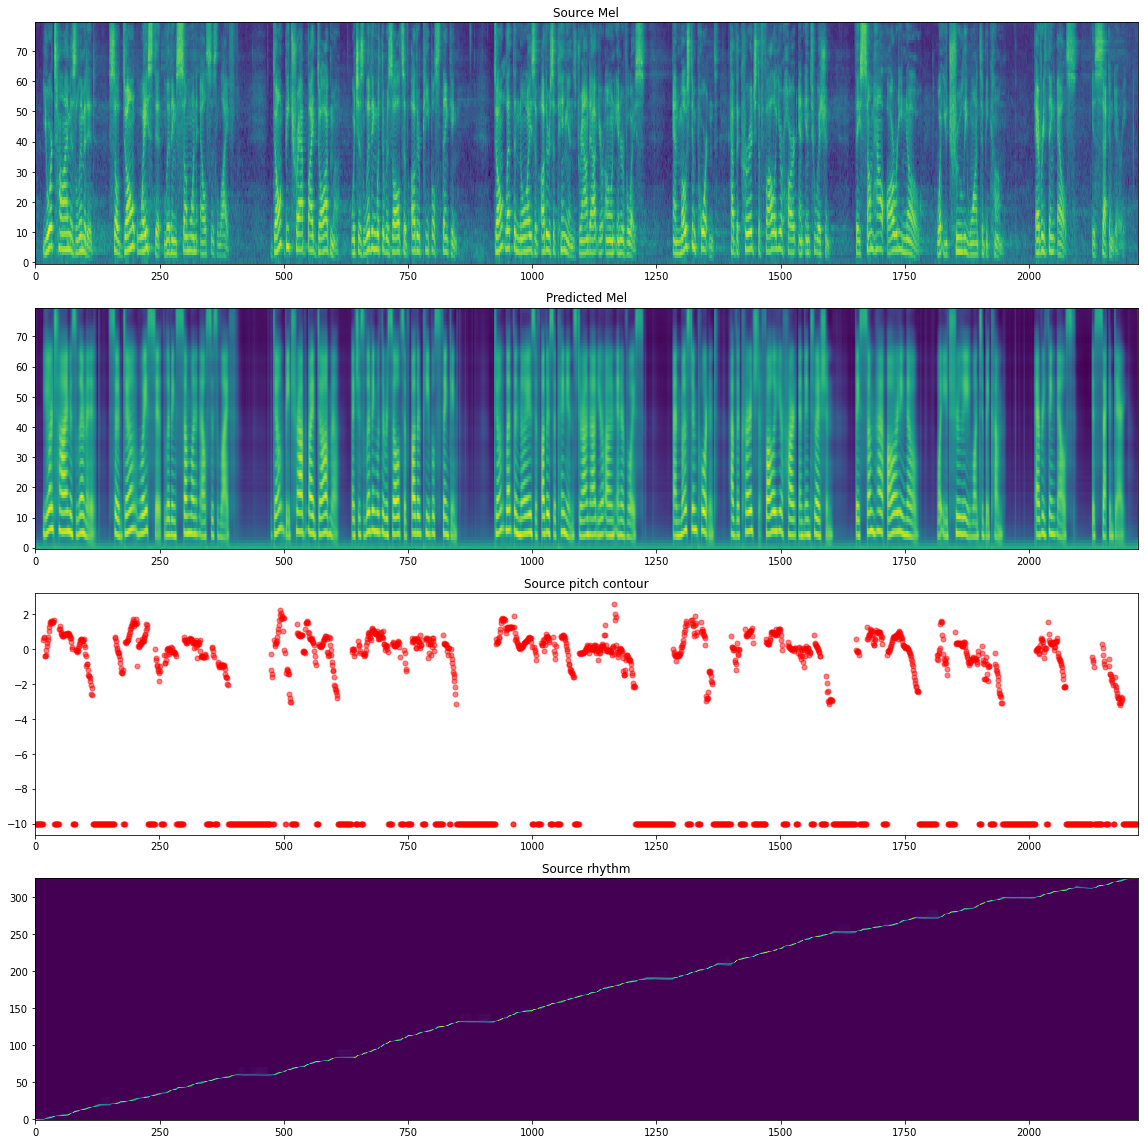

In [ ]:
with torch.no_grad():       
    plot_mel_f0_alignment(mel_source.data.cpu().numpy()[0],
                          mel_predicted.data.cpu().numpy()[0],
                          f0_padded.cpu().numpy()[0, 0],
                          alignment.data.cpu().numpy()[0].T)

## Convert spectrogram to audio using vocoder

In [ ]:
with torch.no_grad():
    y_g_hat = generator(mel_predicted)
    audio = y_g_hat.squeeze()
    audio = audio * MAX_WAV_VALUE
    audio = audio.detach().cpu().numpy().astype('int16')

In [ ]:
ipd.Audio(audio, rate=hp.audio.sampling_rate)

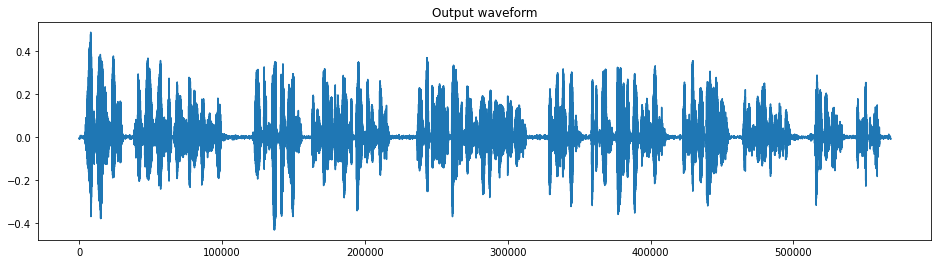

In [ ]:
plt.figure(figsize=(16,4))
plt.title("Output waveform")
plt.plot(audio / MAX_WAV_VALUE)
plt.show()